<a href="https://colab.research.google.com/github/wkdth04/hanghae99AI3th/blob/%EA%B3%BC%EC%A0%9C/(%EC%B5%9C%EC%A2%85)2%EC%A3%BC%EC%B0%A8_Transformer%EC%8B%A4%EC%8A%B5_%EC%9E%A5%EC%86%8C%EC%97%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 토큰화 및 텍스트 전처리 라이브러리로 Hugging Face Transformers라이브러리에서 사용하는 Moses Tokenizer기반 동작
!pip install datasets sacremoses

In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
#추가
from torch.nn.utils.rnn import pad_sequence
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


# ds = load_dataset("stanfordnlp/imdb") -> IMDB 영화 리뷰 데이터 셋을 가져옴/로드함
train_ds = load_dataset("stanfordnlp/imdb", split="train")
test_ds = load_dataset("stanfordnlp/imdb", split="test")

#BertTokenizerFast를 사용하여 텍스트를 토큰화(BERT토크나이저)
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

# collate_fn 수정 — 마지막 단어 예측용으로 변형
def collate_fn(batch):
  max_len = 400
  texts, labels = [], []

  for row in batch:
    tokenized = tokenizer(row['text'], truncation=True, max_length=max_len, add_special_tokens=False).input_ids
    if len(tokenized) < 2:
      continue
    labels.append(tokenized[-1])  # 마지막 단어 (진짜 단어)
    texts.append(torch.LongTensor(tokenized[:-1]))  # 마지막 단어 제외하고 입력

  if len(texts) == 0:
    return torch.LongTensor([[tokenizer.pad_token_id]]), torch.LongTensor([0])

  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels
'''2차수정
def collate_fn(batch): ### 여기가 수정부분
  max_len = 400
  texts, labels = [], []

  for row in batch:
    tokenized = tokenizer(row['text'], truncation=True, max_length=max_len).input_ids
    labels.append(tokenized[-1])  # 마지막 token을 예측 대상
    texts.append(torch.LongTensor(tokenized[:-1]))  # 마지막 token 제거한 input
                                                    # 마지막 token 하나만 정답(label)로 사용

  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels'''
'''1차수정
#collate_fn을 정의하여 배치별 데이터 처리
def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels
'''

train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


## Self-attention

이번에는 self-attention을 구현해보겠습니다.
Self-attention은 shape이 (B, S, D)인 embedding이 들어왔을 때 attention을 적용하여 새로운 representation을 만들어내는 module입니다.
여기서 B는 batch size, S는 sequence length, D는 embedding 차원입니다.
구현은 다음과 같습니다.


(추가)[참고]
TextClassifier가 사용하는 SelfAttention 클래스는
TransformerLayer 클래스 안에서 사용되고,
TransformerLayer는 SelfAttention에 의존합니다.

아래 순서로 진행
1.SelfAttention 클래스 정의
2.TransformerLayer 클래스 정의
3.TextClassifier 클래스 정의
4.model = TextClassifier(...) 실행

In [ ]:
from torch import nn
from math import sqrt

# SelfAttention 클래스 정의
#Single-head Self-Attentionx
class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

#쿼리(Q), 키(K), 값(V)를 생성하고, 스케일링 후 소프트맥스를 적용하여 가중합을 구한다
  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model) #sqrt(d_model)으로 나눠서 값 안정화

    if mask is not None:
      score = score + (mask * -1e9)

    #softmax로 attention weight 생성
    score = self.softmax(score)
    result = torch.matmul(score, v) #weighted sum 결과
    result = self.dense(result) #다른 차원으로 다시매핑

    return result

대부분은 Transformer 챕터에서 배운 수식들을 그대로 구현한 것에 불과합니다.
차이점은 `mask`의 존재여부입니다.
이전 챕터에서 우리는 가변적인 text data들에 padding token을 붙여 하나의 matrix로 만든 방법을 배웠습니다.
실제 attention 계산에서는 이를 무시해주기 위해 mask를 만들어 제공해주게 됩니다.
여기서 mask의 shape은 (B, S, 1)로, 만약 `mask[i, j] = True`이면 그 변수는 padding token에 해당한다는 뜻입니다.
이러한 값들을 무시해주는 방법은 shape이 (B, S, S)인 `score`가 있을 때(수업에서 배운 $A$와 동일) `score[i, j]`에 아주 작은 값을 더해주면 됩니다. 아주 작은 값은 예를 들어 `-1000..00 = -1e9` 같은 것이 있습니다.
이렇게 작은 값을 더해주고 나면 softmax를 거쳤을 때 0에 가까워지기 때문에 weighted sum 과정에서 padding token에 해당하는 `v` 값들을 무시할 수 있게 됩니다.

다음은 self-attention과 feed-forward layer를 구현한 모습입니다.

In [ ]:
#Transformer Layer
#Self-Attention을 적용한 후 피드포워드 네트워크를 통과

class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential( #ffn -> feed-forward 네트워크
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)
    return x

보시다시피 self-attention의 구현이 어렵지, Transformer layer 하나 구현하는 것은 수업 때 다룬 그림과 크게 구분되지 않는다는 점을 알 수 있습니다.

## Positional encoding

이번에는 positional encoding을 구현합니다. Positional encoding의 식은 다음과 같습니다:
$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

이를 Numpy로 구현하여 PyTorch tensor로 변환한 모습은 다음과 같습니다:

In [ ]:
#Positional Encoding 정의
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

#위치 정보를 반영하기 위해 사인 및 코사인 함수를 활용한 포지셔널 인코딩을 추가
#위치별로 주기적 신호(사인/코사인)을 다르게 넣어줘서 모델이 위치를 감지할 수 있게 함
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    #짝수인덱스 : sin(사인)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    #홀수인덱스 : cos(코사인)
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400 # 이 값도 모델과 함께 사용

'''
print(positional_encoding(max_len, 256).shape)'''

'\nprint(positional_encoding(max_len, 256).shape)'

Positional encoding은 `angle_rads`를 구현하는 과정에서 모두 구현이 되었습니다. 여기서 `angle_rads`의 shape은 (S, D)입니다.
우리는 일반적으로 batch로 주어지는 shape이 (B, S, D)인 tensor를 다루기 때문에 마지막에 None을 활용하여 shape을 (1, S, D)로 바꿔주게됩니다.

위에서 구현한 `TransformerLayer`와 positional encoding을 모두 합친 모습은 다음과 같습니다:

In [ ]:
#Text Classifier정의
#임베딩, 포지셔널 인코딩, Transformer 레이어, 그리고 최종분류 층을 포함한 텍스트 분류 모델을 정의
#classification -> vocab_size, 출력 위치도 변경

class TextClassifier(nn.Module):  ### 여기가 수정부분
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, vocab_size)  # 마지막 단어 분류

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.embedding.embedding_dim)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, -1]  # 마지막 위치만 출력
    x = self.classification(x)

    return x

model = TextClassifier(len(tokenizer), 32, 2, 32)

'''
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    #학습되지 않는 파라미터로 위치정보 고정
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 1)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    #정적인 positional encoding을 임베딩에 더해서 사용
    #이 방식은 학습 없이도 순서 정보가 모델에 주입됨
    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x


model = TextClassifier(len(tokenizer), 32, 2, 32)'''

'\nclass TextClassifier(nn.Module):\n  def __init__(self, vocab_size, d_model, n_layers, dff):\n    super().__init__()\n\n    self.vocab_size = vocab_size\n    self.d_model = d_model\n    self.n_layers = n_layers\n    self.dff = dff\n\n    self.embedding = nn.Embedding(vocab_size, d_model)\n    #학습되지 않는 파라미터로 위치정보 고정\n    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)\n    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])\n    self.classification = nn.Linear(d_model, 1)\n\n  def forward(self, x):\n    mask = (x == tokenizer.pad_token_id)\n    mask = mask[:, None, :]\n    seq_len = x.shape[1]\n\n    #정적인 positional encoding을 임베딩에 더해서 사용 \n    #이 방식은 학습 없이도 순서 정보가 모델에 주입됨\n    x = self.embedding(x)\n    x = x * sqrt(self.d_model)\n    x = x + self.pos_encoding[:, :seq_len]\n\n    for layer in self.layers:\n      x = layer(x, mask)\n\n    x = x[:, 0]\n    x = self.classification(x)\n\n   

기존과 다른 점들은 다음과 같습니다:
1. `nn.ModuleList`를 사용하여 여러 layer의 구현을 쉽게 하였습니다.
2. Embedding, positional encoding, transformer layer를 거치고 난 후 마지막 label을 예측하기 위해 사용한 값은 `x[:, 0]`입니다. 기존의 RNN에서는 padding token을 제외한 마지막 token에 해당하는 representation을 사용한 것과 다릅니다. 이렇게 사용할 수 있는 이유는 attention 과정을 보시면 첫 번째 token에 대한 representation은 이후의 모든 token의 영향을 받습니다. 즉, 첫 번째 token 또한 전체 문장을 대변하는 의미를 가지고 있다고 할 수 있습니다. 그래서 일반적으로 Transformer를 text 분류에 사용할 때는 이와 같은 방식으로 구현됩니다.

## 학습

학습하는 코드는 기존 실습들과 동일하기 때문에 마지막 결과만 살펴보도록 하겠습니다.

In [ ]:
from torch.optim import Adam
#추가(이건 단어 예측처럼 클래스 개수가 많을 때 (여기선 vocab_size만큼) 사용하는 손실 함수)
#수정 전: BCEWithLogitsLoss() ← 이진 분류용
#수정 후: CrossEntropyLoss() ← 다중 클래스 분류용 (단어 예측)
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss() # 손실함수 수정 - BCE -> CrossEntropy

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)
model = model.to('cuda')


'''
# BCEWithLogisticLoss를 손실 함수로 사용하고 Adam옵티마이저를 활용하여 학습
loss_fn = nn.BCEWithLogitsLoss()
'''

'\n# BCEWithLogisticLoss를 손실 함수로 사용하고 Adam옵티마이저를 활용하여 학습\nloss_fn = nn.BCEWithLogitsLoss()\n'

In [ ]:
# 정확도 계산도 argmax기준으로 변경
import numpy as np
import matplotlib.pyplot as plt

def accuracy(model, dataloader): #이부분 수정
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    acc += (preds == labels).sum().item()
    cnt += labels.shape[0]

  return acc / cnt



'''
#accuracy함수를 정의하여 모델의 정확도 평가
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt'''

"\n#accuracy함수를 정의하여 모델의 정확도 평가\ndef accuracy(model, dataloader):\n  cnt = 0\n  acc = 0\n\n  for data in dataloader:\n    inputs, labels = data\n    inputs, labels = inputs.to('cuda'), labels.to('cuda')\n\n    preds = model(inputs)\n    # preds = torch.argmax(preds, dim=-1)\n    preds = (preds > 0).long()[..., 0]\n\n    cnt += labels.shape[0]\n    acc += (labels == preds).sum().item()\n\n  return acc / cnt"

🎯 디버깅 출력 시작
loss: 10.283707618713379
labels dtype: torch.int64
labels sample: tensor([6582, 1012, 1012, 1012, 9055], device='cuda:0')
preds shape: torch.Size([64, 30522])
preds sample: tensor([ 0.2103, -0.1811, -0.1987, -0.0881, -0.1216], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch   0 | Avg Train Loss: 0.0000
Epoch   1 | Avg Train Loss: 3.6570
Epoch   2 | Avg Train Loss: 2.7941
Epoch   3 | Avg Train Loss: 2.6600
Epoch   4 | Avg Train Loss: 2.6107
Epoch   5 | Avg Train Loss: 2.5806
Epoch   6 | Avg Train Loss: 2.5560
Epoch   7 | Avg Train Loss: 2.5413
Epoch   8 | Avg Train Loss: 2.5074
Epoch   9 | Avg Train Loss: 2.4840
Epoch  10 | Avg Train Loss: 2.4511
Epoch  11 | Avg Train Loss: 2.4179
Epoch  12 | Avg Train Loss: 2.3844
Epoch  13 | Avg Train Loss: 2.3512
Epoch  14 | Avg Train Loss: 2.3202
Epoch  15 | Avg Train Loss: 2.2787
Epoch  16 | Avg Train Loss: 2.2463
Epoch  17 | Avg Train Loss: 2.2147
Epoch  18 | Avg Train Loss: 2.1844
Epoch  19 | Avg Train Loss: 2.1407
Epoch  20 |

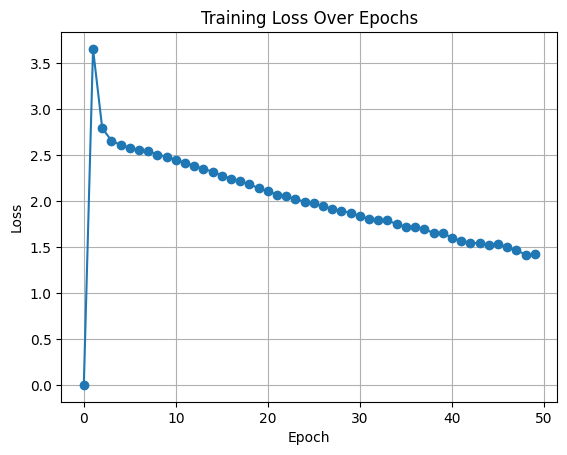

In [ ]:
n_epochs = 50
train_losses = [] #에폭별 평균 loss 저장용 리스트

#학습루프 부분 수정
for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)



    # ✅ 여기부터 디버깅용 출력
    if epoch == 0 and total_loss == 0:  # 첫 에폭의 첫 배치만 출력
        print("🎯 디버깅 출력 시작")
        print("loss:", loss.item())
        print("labels dtype:", labels.dtype)
        print("labels sample:", labels[:5])
        print("preds shape:", preds.shape)
        print("preds sample:", preds[0][:5])
        break  # 첫 배치만 확인


    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  #loss 그래프 시각화
  avg_loss = total_loss / len(train_loader)  # 🔸 평균 loss 계산
  train_losses.append(avg_loss)  # 🔸 loss 저장

  print(f"Epoch {epoch:3d} | Avg Train Loss: {avg_loss:.4f}")

# 결과출력
with torch.no_grad():
  model.eval()
  train_acc = accuracy(model, train_loader)
  test_acc = accuracy(model, test_loader)
  print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

'''
  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")
'''

# 🔻 학습 loss 시각화
import matplotlib.pyplot as plt
plt.plot(train_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

학습이 안정적으로 진행되며 RNN보다 빨리 수렴하는 것을 확인할 수 있습니다.
하지만 test 정확도가 RNN보다 낮은 것을 보았을 때, overfitting에 취약하다는 것을 알 수 있습니다.